In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

In [307]:
df = pd.read_csv('yahoo_stock.csv')

In [308]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


We are going to be working on the open and close data and try to predict the open and closing prices of yahoo stocks

In [309]:
yahoo_open = df[['Open', 'Date']].copy()
yahoo_close = df[['Close', 'Date']].copy()

In [293]:
yahoo_open.head()

,Open,Date
0,2089.409912,2015-11-23
1,2084.419922,2015-11-24
2,2089.300049,2015-11-25
3,2089.300049,2015-11-26
4,2088.820068,2015-11-27


In [294]:
yahoo_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1825 non-null   float64
 1   Date    1825 non-null   object 
dtypes: float64(1), object(1)
memory usage: 28.6+ KB


In [295]:
yahoo_close.head()

,Close,Date
0,2086.590088,2015-11-23
1,2089.139893,2015-11-24
2,2088.870117,2015-11-25
3,2088.870117,2015-11-26
4,2090.110107,2015-11-27


In [296]:
yahoo_close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1825 non-null   float64
 1   Date    1825 non-null   object 
dtypes: float64(1), object(1)
memory usage: 28.6+ KB


converting Date to timestamp and restting index

In [315]:
yahoo_open['Date'] = pd.to_datetime(yahoo_open['Date'])
yahoo_open.set_index(['Date'],inplace = True)


In [316]:
yahoo_close['Date'] = pd.to_datetime(yahoo_close['Date'])
yahoo_close.set_index(['Date'],inplace = True)

# Open Stocks Data
We will forst look at yahoo's stock opening data

In [299]:
yahoo_open.head()

,Open
Date,
2015-11-23,2089.409912
2015-11-24,2084.419922
2015-11-25,2089.300049
2015-11-26,2089.300049
2015-11-27,2088.820068


The data is daily data which is hard to forecast and hence have to be resampled into Monthly data

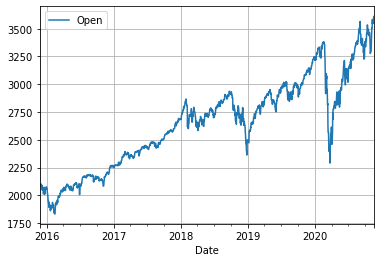

In [300]:
yahoo_open.plot(grid = True)

We see a major dip in yahoo stokcs somewhere arround the start of 2020. Lets analyze that area more.

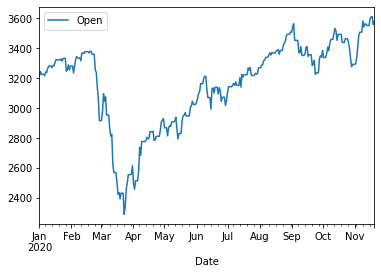

In [301]:
yahoo_open_2020 = yahoo_open['01-01-2020' : '31-12-2020']
yahoo_open_2020.plot()

There is dip in the stock prices statring from the month of March and going up after April. This is also the time around which COVID hit the countries and most of the world was on lockdown. So the dip is justified.

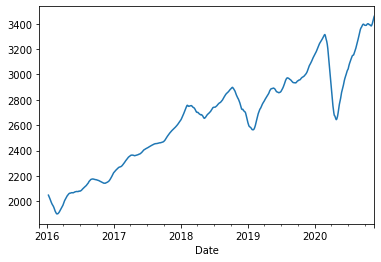

In [302]:
#smoothen out sereis to check for seasonality
yahoo_open_rolling = yahoo_open['Open'].rolling(window = 50).mean()
yahoo_open_rolling.plot()

In [328]:
#Converting data to monthly data
yahoo_open = yahoo_open.resample('MS').mean()

In [329]:
yahoo_open.shape

(61, 1)

## Staionarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_open = adfuller(yahoo_open['Open'], autolag='AIC')

print(f'ADF Statistics : {adf_open[0]}')
print(f'p-value : {adf_open[1]}')

for key, value in adf_open[4].items() :
  print('Criteria Value')
  print(f'{key}:{value}')

ADF Statistics : -0.40903069505155853
p-value : 0.908580020524435
Criteria Value
1%:-3.5443688564814813
Criteria Value
5%:-2.9110731481481484
Criteria Value
10%:-2.5931902777777776


Since p-value is not < 0.05 the open and close stock series is not Stationary 

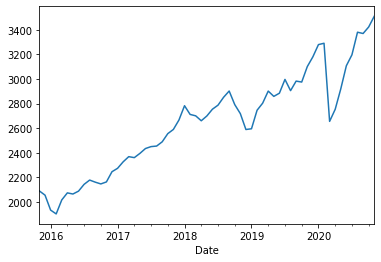

In [332]:
yahoo_open['Open'].plot()

Not much information can be gained abput seasonality from this plot about the stock data. Lets do Seasonal Decompose to get a better idea.

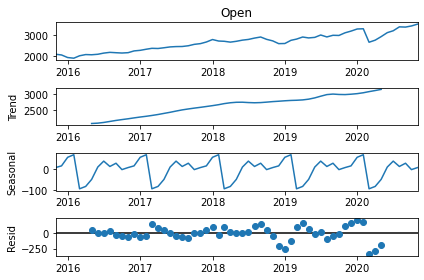

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
open = seasonal_decompose(yahoo_open['Open'].dropna())
x = open.plot()

From the plot we can see that there is some seasonal trend in our series.

In [ ]:
#Differencing the series to make it Stationary 
#Open Stock Price Data
yahoo_open['First Differencing'] = yahoo_open['Open'] - yahoo_open['Open'].shift()
yahoo_open['Seasonal Differencing'] = yahoo_open['Open'] - yahoo_open['Open'].shift(12)

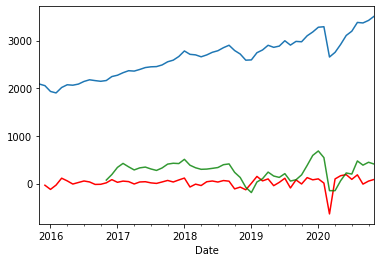

In [ ]:
#Plot Open Data 
yahoo_open['Open'].plot()
yahoo_open['First Differencing'].plot(color = 'red')
yahoo_open['Seasonal Differencing'].plot(color = 'green', alpha = 0.8)

A first level differencing makes the series Stationary therefore we will set d=1;


In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_open = adfuller(yahoo_open['Seasonal Differencing'].dropna(), autolag='AIC')

print(f'ADF Statistics : {adf_open[0]}')
print(f'p-value : {adf_open[1]}')

for key, value in adf_open[4].items() :
  print('Criteria Value')
  print(f'{key}:{value}')

ADF Statistics : -4.183162771153319
p-value : 0.0007035012952065601
Criteria Value
1%:-3.5778480370438146
Criteria Value
5%:-2.925338105429433
Criteria Value
10%:-2.6007735310095064


Since p-value has gotten <0.05 after first differencing we will set d=1;

## Doing ACF and PACF plot to find AR and MA terms for the ARIMA model.

In [ ]:
yahoo_open.head()

,Open,First Differencing,Seasonal Differencing
Date,,,
2015-11-01,2088.730011,NaN,NaN
2015-12-01,2054.881942,-33.848069,NaN
2016-01-01,1933.377111,-121.504832,NaN
2016-02-01,1902.269641,-31.107470,NaN
2016-03-01,2016.150962,113.881321,NaN


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

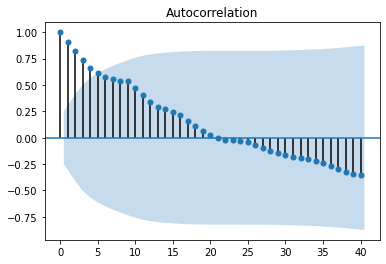

In [ ]:
MA_term = plot_acf(yahoo_open['Open'].dropna(), lags = 40)


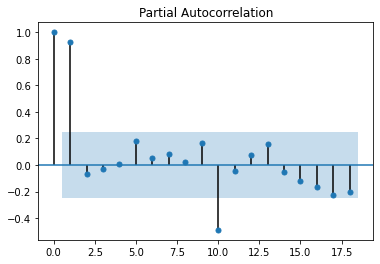

In [ ]:
AR_term = plot_pacf(yahoo_open['Open'].dropna())


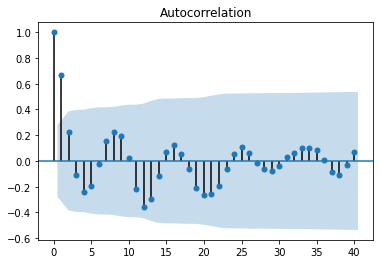

In [ ]:
MA_Seasonal_term = plot_acf(yahoo_open['Seasonal Differencing'].dropna(), lags = 40)

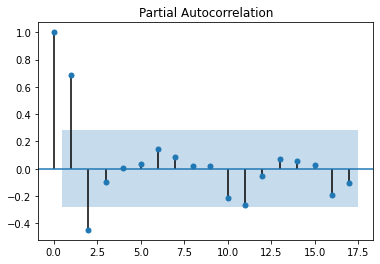

In [ ]:
AR_Seasonal_term = plot_pacf(yahoo_open['Seasonal Differencing'].dropna())

## Training ARIMA Model
Training ARIMA model for Open Stocks Data

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(yahoo_open['Open'], order = (1,1,4), seasonal_order = (1,1,2,12))
result = model.fit()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
yahoo_open['Open'].shape

(61,)

In [ ]:
train = yahoo_open[:50]
test = yahoo_open[51:]
start = len(train)
end =len(train)+len(test)-1


In [ ]:
yahoo_open['forecast'] = result.predict(start=start, end=end, dynamic=True)

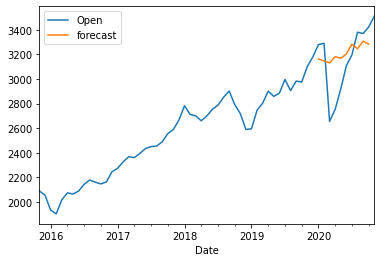

In [ ]:
yahoo_open[['Open', 'forecast']].plot()

In [ ]:
FutureForecast = result.predict(start = len(yahoo_open), end = len(yahoo_open) + 20, dynamic = True )

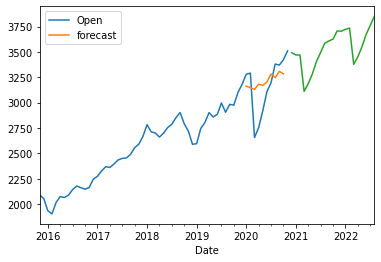

In [ ]:
yahoo_open[['Open', 'forecast']].plot()
FutureForecast.plot()